In [2]:
%matplotlib inline
import warnings

def get_warning():
    warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    get_warning()
    
import os
import pandas as pd
import sys
import glob
import json
import time

import nibabel as nib
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
from scipy.ndimage import morphology
from scipy.signal import convolve

# Import data science modules
from scipy import interp, ndimage

# Import graphing modules
import matplotlib
import matplotlib.pyplot as plt

# Import machine learning modules
from sklearn import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.externals import joblib

sys.path.append(os.path.expanduser('~/gdrive/aim3/code'))

with open(os.path.expanduser('~/gdrive/aim3/code/data/DATA.json')) as json_data_file:
    data = json.load(json_data_file)


def gather_results(dilate_radius, fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Find pipedef file
        for fn in os.listdir(comp_dir):
            if('pipedef' in fn):
                # Open pipedef
                pipedef = json.load(open('%s/%s'%(comp_dir,fn),'r'))
                # determine if correction dilation
                if(np.float(pipedef['dilate_radius']) == np.float(dilate_radius)):
                    unique_id = fn.split('.')[4]
                    results[patient_id] = {}
                    break

        # Open all cres
        try:
            for fn in os.listdir(comp_dir):
                if('cres.%s'%(unique_id) in fn and 'pipedef' not in fn):
                    results[patient_id][fn.split('.')[2]] = np.load('%s/%s'%(comp_dir,fn))['control_centrality_%s'%fconn]
        except:
            continue

    return results

def gather_adj_results(fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Open all adj
        try:
            for fn in os.listdir(comp_dir):
                if('multiband' in fn):
                    if(patient_id not in results.keys()):
                        results[patient_id] = {}
                    results[patient_id][fn.split('.')[2]] = np.load('%s/%s'%(comp_dir,fn))['all_adj_%s'%fconn]
        except:
            continue

    return results

def get_outcome(outcome):
    """
    Function for determing poor and favorable surgical outcome.
    Parameters
    ----------
        outcome: str
            Surgical outcome as either Engel or ILAE.

    Returns
    -------
        str
            Returns either good or bad.
    """
    switcher = {
        '1': 'Good',
        '1.1': 'Good',
        '1.2': 'Good',
        '1.3': 'Good',
        '1.4': 'Good',
        '1A': 'Good',
        '1B': 'Good',
        '1C': 'Good',
        '1D': 'Good',
        'IA': 'Good',
        'IB': 'Good',
        'IC': 'Good',
        'ID': 'Good',
        '2': 'Poor',
        '2.1': 'Poor',
        '2.2': 'Poor',
        '2.3': 'Poor',
        '2.4': 'Poor',
        '2a': 'Poor',
        '2b': 'Poor',
        '2c': 'Poor',
        '2d': 'Poor',
        '3': 'Poor',
        '4': 'Poor',
        'II': 'Poor',
        'III': 'Poor',
        'IV': 'Poor',
        'ILAE1': 'Good',
        'ILAE2': 'Good',
        'ILAE3': 'Poor',
        'ILAE4': 'Poor',
        'ILAE5': 'Poor'
    }

    return switcher.get(outcome, "Good")


/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.Line

<h1> Feature computation for Virtual Resection model </h1>

In [5]:
dilate_radius = 0
skip_chop = False
skip_mayo = False
skip_hup = False

pt_iter = 0
all_cres = gather_results(0, 'broadband_CC')
patient_idx = all_cres.keys()
if(skip_chop):
    ft_matrix = np.zeros((20,9000+2))
else:
    ft_matrix = np.zeros((len(all_cres.items()),9000+2))
out_txt = 'pt_id,' #First column
index_col = []

for patient_id in patient_idx:
    print patient_id
    if(skip_chop and 'CHOP' in patient_id):
        continue
    if(skip_mayo and 'Study' in patient_id):
        continue
    if(skip_hup and 'HUP' in patient_id):
        continue
    index_col.append(patient_id)
    row_data = np.array((pt_iter+1,))
    for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma','veryhigh']:
        for zscore in [True, False]:
            # All cres
            all_cres = gather_results(dilate_radius, fconn)

            for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue

                outcome = data['PATIENTS'][patient_id]['Outcome']
                avg_data = np.array(())
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    if(clip_data.shape[0] == 901):
                        clip_data = clip_data[:900]
                    try:
                        avg_data = np.hstack((avg_data,np.reshape(clip_data,(900,1))))
                    except Exception:
                        avg_data = np.reshape(clip_data,(900,1))
                avg_data = np.nanmean(avg_data,axis=1)

                # Apply z score normalization
                if(zscore):
                    tmp = avg_data[:].squeeze()
                    avg_data[~np.isnan(tmp)] = scipy.stats.zscore(tmp[~np.isnan(tmp)])

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,901):
                        if(zscore):
                            out_txt += 'cres_t_'+str(t)+'_%s_zscore,'%fconn
                        else:
                            out_txt += 'cres_t_'+str(t)+'_%s,'%fconn
    if(get_outcome(outcome) == 'Good'):        
        row_data = np.hstack((row_data,[0]))        
    else:
        row_data = np.hstack((row_data,[1]))
    if(row_data.shape[0] != 9000+2):
        continue
    ft_matrix[pt_iter,:] = row_data
    pt_iter += 1
    
out_txt += 'Outcome'

df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

comp_dir = os.path.expanduser(data['COMP_DIR'])
df.to_csv('%s/../code/data/VRmodel.csv'%comp_dir)

Study022
Study020
Study029
Study028
HUP078
HUP074
HUP075
HUP073
HUP070
CHOP46
CHOP47
CHOP08
CHOP27
CHOP20
Study019
Study012
CHOP42


/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


CHOP45
Study016
Study017
CHOP40
CHOP43
HUP086
HUP083
HUP082
HUP080
HUP087
HUP068
HUP065
HUP064
HUP088
CHOP38
CHOP14


In [24]:
dilate_radius = 0
skip_chop = False
skip_mayo = False
skip_hup = False

pt_iter = 0
all_adj = gather_adj_results('broadband_CC')
patient_idx = all_adj.keys()
if(skip_chop):
    ft_matrix = np.zeros((20,900+2))
else:
    ft_matrix = np.zeros((len(all_cres.items()),900+2))
out_txt = 'pt_id,' #First column
index_col = []

for patient_id in patient_idx:
    print patient_id
    if(skip_chop and 'CHOP' in patient_id):
        continue
    if(skip_mayo and 'Study' in patient_id):
        continue
    if(skip_hup and 'HUP' in patient_id):
        continue
    index_col.append(patient_id)
    row_data = np.array((pt_iter+1,))
    for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma','veryhigh']:
        for pid,clips in sorted(all_cres.items(), key=lambda x:x[0]):
            if(pid != patient_id):
                continue
            all_adj = gather_adj_results(fconn)
            outcome = data['PATIENTS'][patient_id]['Outcome']
            avg_data = np.array(())
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                try:
                    avg_data = np.hstack((avg_data,np.reshape(clip_data,(900,1))))
                except Exception:
                    avg_data = np.reshape(clip_data,(900,1))
            avg_data = np.nanmean(avg_data,axis=1)

            # Apply z score normalization
            if(zscore):
                tmp = avg_data[:].squeeze()
                avg_data[~np.isnan(tmp)] = scipy.stats.zscore(tmp[~np.isnan(tmp)])

            # Update row_data
            row_data = np.hstack((row_data,avg_data)) 

            # Update header
            if(pt_iter == 0):
                for t in range(1,901):
                    if(zscore):
                        out_txt += 'cres_t_'+str(t)+'_%s_zscore,'%fconn
                    else:
                        out_txt += 'cres_t_'+str(t)+'_%s,'%fconn
    if(get_outcome(outcome) == 'Good'):        
        row_data = np.hstack((row_data,[0]))        
    else:
        row_data = np.hstack((row_data,[1]))
    if(row_data.shape[0] != 9000+2):
        continue
    ft_matrix[pt_iter,:] = row_data
    pt_iter += 1
    
out_txt += 'Outcome'

df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

comp_dir = os.path.expanduser(data['COMP_DIR'])
df.to_csv('%s/../code/data/null1_VRmodel.csv'%comp_dir)

Study022
Study020
Study029
Study028
HUP078
HUP074
HUP075
HUP073
HUP070
CHOP46
CHOP47
CHOP08
CHOP27
CHOP20
Study012
CHOP42
CHOP45
Study016
Study017
CHOP40
CHOP43
HUP086
HUP083
HUP082
HUP080
HUP087
HUP068
HUP065
HUP064
HUP088
CHOP38
CHOP14
Study022
Study020
Study029
Study028
HUP078
HUP074
HUP075
HUP073
HUP070
CHOP46
CHOP47
CHOP08
CHOP27
CHOP20
Study012
CHOP42
CHOP45
Study016
Study017
CHOP40
CHOP43
HUP086
HUP083
HUP082
HUP080
HUP087
HUP068
HUP065
HUP064
HUP088
CHOP38
CHOP14
Study022
Study020
Study029
Study028
HUP078
HUP074
HUP075
HUP073
HUP070
CHOP46
CHOP47
CHOP08
CHOP27
CHOP20
Study012
CHOP42
CHOP45
Study016
Study017
CHOP40
CHOP43
HUP086
HUP083
HUP082
HUP080
HUP087
HUP068
HUP065
HUP064
HUP088
CHOP38
CHOP14
Study022
Study020
Study029
Study028
HUP078
HUP074
HUP075
HUP073
HUP070
CHOP46
CHOP47
CHOP08
CHOP27
CHOP20
Study012
CHOP42
CHOP45
Study016
Study017
CHOP40
CHOP43
HUP086
HUP083
HUP082
HUP080
HUP087
HUP068
HUP065
HUP064
HUP088
CHOP38
CHOP14
Study022
Study020
Study029
Study028
HUP078
HUP07

<h1> Feature computation for Taylor-Cash model </h1>

<h1> Cross Validation of Model 1 : Virtual Resection </h1>
This model uses network features $c_{res}(t)$ and $|c_{res}(t)|$ across all 1 second epochs in a 15 minutes window surrounding the EEC. Polynomial and interaction terms (degree 2) are used to build features.

Generating feature matrix ...
Feature reduction to 30 features ...
Performing cross validation ...
Computing AUC of ROC ...


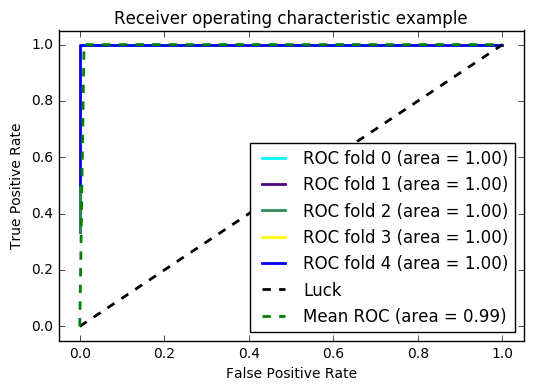

Mean AUC: 0.995 $\pm$ 0.071


In [3]:
# Parameters
k1 = 30 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Load DataFrame
df = pd.read_csv('~/gdrive/aim3/code/data/VRmodel.csv')
if(True):
    df = df.dropna()
    
# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y = np.array(df.Outcome)

if(False):
    imp = Imputer(missing_values = 'NaN', strategy='mean', axis=0)
    X = imp.fit(X).transform(X)    

# Build a Random Forest with 1000 estimators
classifier_VR = RandomForestClassifier(n_estimators=1000)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier_VR.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)

# Compute 8-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
# to generate ROC curves.
print 'Performing cross validation ...'
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=16)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

from itertools import cycle
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0

# for (train, test) in cv.split(X,y):
for (train, test), color in zip(cv.split(X, y), colors):
    # Ignore any folds that do not have any poor outcomes 
    # to maintain representation of entire dataset.
    if(sum(y[test]) == 0):
        print train,test
        continue
    probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',label='Luck')

# Compute mean Area Under Curve (AUC)    
print 'Computing AUC of ROC ...'
mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc_VR = auc(mean_fpr, mean_tpr)
sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)

plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc_VR, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute Mean AUC and Confidence interval using \sigma_max
print "Mean AUC: %0.3f $\pm$ %0.3f"%(mean_auc_VR,sigma_auc_VR)

In [4]:
# Parameters
k1 = 30 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Load DataFrame
df = pd.read_csv('~/gdrive/aim3/code/data/VRmodel.csv')
if(True):
    df = df.dropna()
    
# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y_real = np.array(df.Outcome)

all_mean_auc = []

for perm_iter in range(100):
    print perm_iter
    y = np.random.permutation(y_real)
    # Build a Random Forest with 1000 estimators
    classifier_VR = RandomForestClassifier(n_estimators=1000)

    # Perform the first prune using ANOVA F test using mutual information
#     print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
    prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
    X = prune1.fit_transform(X,y)

    # # Perform a second prune by selecting features optimally branched using the classifier
    # print 'Second round of feature reduction ...'
    # clf = classifier_VR.fit(X,y)
    # model = SelectFromModel(clf, prefit=True)
    # X = model.transform(X)

    # # Generate polynomial (degree 2) with interaction term feature set to account 
    # # for non-linear combinations.
    # # This will include cross-interaction terms to take into account non-linear combinations 
    # # of clinical variables.
    # print 'Generating polynomial combination of features ...'
    # poly = PolynomialFeatures(2)
    # X = poly.fit_transform(X)

    # # Perform the third prune using ANOVA F test using mutual information
    # print 'Final round of feature reduction to %i features ...'%k2
    # prune2 = SelectKBest(mutual_info_classif, k=k2)
    # X = prune2.fit_transform(X,y)

    # Compute 8-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
    # to generate ROC curves.
#     print 'Performing cross validation ...'
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    from itertools import cycle
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    i = 0

    # for (train, test) in cv.split(X,y):
    for (train, test), color in zip(cv.split(X, y), colors):
        # Ignore any folds that do not have any poor outcomes 
        # to maintain representation of entire dataset.
        if(sum(y[test]) == 0):
            print train,test
            continue
        probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        i += 1

    # Compute mean Area Under Curve (AUC)    
#     print 'Computing AUC of ROC ...'
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc_VR = auc(mean_fpr, mean_tpr)
    sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)
    all_mean_auc.append(mean_auc_VR)

Generating feature matrix ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


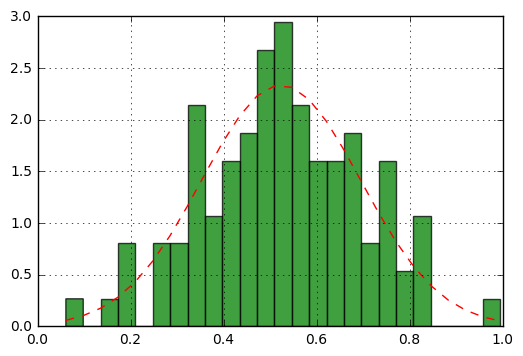

In [9]:
n, bins, patches = plt.hist(all_mean_auc, 25, normed=1, facecolor='green', alpha=0.75)
import matplotlib.mlab as mlab
y = mlab.normpdf(bins, np.mean(all_mean_auc), np.std(all_mean_auc))
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.grid(True)
plt.show()

In [56]:
# Parameters
k1 = 30 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Load DataFrame
df = pd.read_csv('~/gdrive/aim3/code/data/VRmodel.csv')
if(True):
    df = df.dropna()
    
# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y = np.array(df.Outcome)

all_mean_auc = []
    
# Build a Random Forest with 1000 estimators
classifier_VR = RandomForestClassifier(n_estimators=1000)

# Perform the first prune using ANOVA F test using mutual information
#     print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)

X_real = np.copy(X)
y_real = np.copy(y)

for perm_iter in range(100):
    print perm_iter
    X_good = X_real[y_real == 0,:]
    X_poor = X_real[y_real == 1,:]
    from sklearn.utils import shuffle
    X_good = np.array(map(lambda x: shuffle(x), X_good.T)).T
    X_poor = np.array(map(lambda x: shuffle(x), X_poor.T)).T
    X[y_real == 0, :] = X_good
    X[y_real == 1, :] = X_poor    
    if(X==X_real).all():
        blah

    # # Perform a second prune by selecting features optimally branched using the classifier
    # print 'Second round of feature reduction ...'
    # clf = classifier_VR.fit(X,y)
    # model = SelectFromModel(clf, prefit=True)
    # X = model.transform(X)

    # # Generate polynomial (degree 2) with interaction term feature set to account 
    # # for non-linear combinations.
    # # This will include cross-interaction terms to take into account non-linear combinations 
    # # of clinical variables.
    # print 'Generating polynomial combination of features ...'
    # poly = PolynomialFeatures(2)
    # X = poly.fit_transform(X)

    # # Perform the third prune using ANOVA F test using mutual information
    # print 'Final round of feature reduction to %i features ...'%k2
    # prune2 = SelectKBest(mutual_info_classif, k=k2)
    # X = prune2.fit_transform(X,y)

    # Compute 8-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
    # to generate ROC curves.
#     print 'Performing cross validation ...'
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    from itertools import cycle
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    i = 0

    # for (train, test) in cv.split(X,y):
    for (train, test), color in zip(cv.split(X, y), colors):
        # Ignore any folds that do not have any poor outcomes 
        # to maintain representation of entire dataset.
        if(sum(y[test]) == 0):
            print train,test
            continue
        probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        i += 1

    # Compute mean Area Under Curve (AUC)    
#     print 'Computing AUC of ROC ...'
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc_VR = auc(mean_fpr, mean_tpr)
    sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)
    all_mean_auc.append(mean_auc_VR)

Generating feature matrix ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


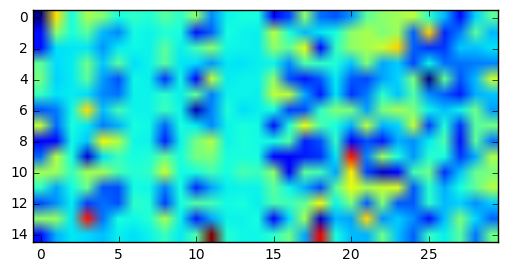

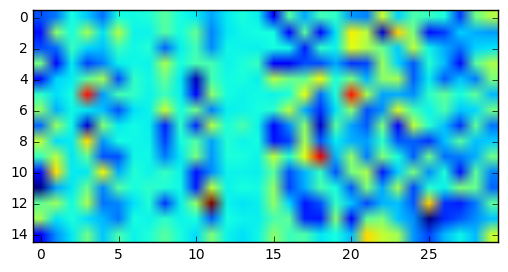

In [55]:
plt.imshow(X_good); plt.show()
X_good = np.array(map(lambda x: shuffle(x), X_good.T)).T
plt.imshow(X_good); plt.show()

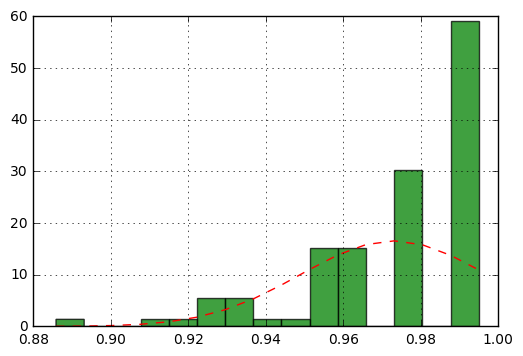

[0.8858585858585859,
 0.90774410774410774,
 0.91952861952861953,
 0.92895622895622898,
 0.92895622895622898,
 0.92929292929292928,
 0.92929292929292928,
 0.92962962962962958,
 0.92962962962962958,
 0.92962962962962958,
 0.9303030303030303,
 0.94107744107744107,
 0.95117845117845112,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185184,
 0.95185185185185195,
 0.95185185185185195,
 0.95185185185185195,
 0.95723905723905722,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.96262626262626261,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.97340067340067338,
 0.973400673

In [57]:
n, bins, patches = plt.hist(all_mean_auc, 15, normed=1, facecolor='green', alpha=0.75)
import matplotlib.mlab as mlab
y = mlab.normpdf(bins, np.mean(all_mean_auc), np.std(all_mean_auc))
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.grid(True)
plt.show()
sorted(all_mean_auc)

In [27]:
tmp = np.random.randint(100,size=(10,5))

In [45]:
print tmp
np.array(map(lambda x: shuffle(x), tmp.T)).T

[[82 15 48 27 83]
 [14 11 90 33 74]
 [62 12 50 25 97]
 [95  9 35 18 44]
 [36 99 64 25 54]
 [70 74 57 68 13]
 [45  0 79  4 52]
 [99 78 59  5 22]
 [99 24 83 93 70]
 [18 69 32  4 84]]


array([[95, 24, 64, 68, 44],
       [14, 99, 90, 25, 74],
       [36, 69, 57, 25, 52],
       [45,  0, 50, 33, 22],
       [18, 15, 32,  4, 83],
       [82, 78, 79,  5, 70],
       [70, 11, 35, 18, 13],
       [62,  9, 59, 93, 54],
       [99, 74, 48, 27, 97],
       [99, 12, 83,  4, 84]])

<h1> Classification of Outcome - ROC Analysis </h1>
<h3> Create developmental and validation cohorts </h3>

In [20]:
# Load all features DataFrame
df = pd.read_csv('~/gdrive/aim3/code/data/VRmodel.csv')
df = df.dropna()

# Determine randomly generated train and test split 
rs = ShuffleSplit(n_splits=1, test_size= 0.33)
for train_index, test_index in rs.split(df['Unnamed: 0']):
    train = train_index
    test = test_index

    
pts = ['Study029','Study028','HUP074','CHOP47','CHOP27','Study019','HUP086','HUP082','HUP080']
test = []
train = []
for kk,pt_id in enumerate(df['Unnamed: 0']):
    if(pt_id in pts):
        test.append(kk)
    else:
        train.append(kk)

train = [0, 1, 4, 6, 7, 8, 9, 11, 13, 15, 16, 17, 18, 20, 23, 24, 25, 26, 27]
test = [2, 3, 5, 10, 12, 14, 19, 21, 22]
print train,test
train_idx = df.iloc[train,:]['Unnamed: 0']
test_idx = df.iloc[test,:]['Unnamed: 0']
print train_idx, test_idx, df.iloc[test,:].Outcome


[0, 1, 4, 6, 7, 8, 9, 11, 13, 15, 16, 17, 18, 20, 23, 24, 25, 26, 27] [2, 3, 5, 10, 12, 14, 19, 21, 22]
0     Study022
1     Study020
4       HUP078
6       HUP075
7       HUP073
8       HUP070
9       CHOP46
11      CHOP08
13      CHOP20
15    Study012
17      CHOP45
18    Study016
19    Study017
23      HUP083
26      HUP087
27      HUP068
28      HUP065
29      HUP064
30      HUP088
Name: Unnamed: 0, dtype: object 2     Study029
3     Study028
5       HUP074
10      CHOP47
12      CHOP27
14    Study019
22      HUP086
24      HUP082
25      HUP080
Name: Unnamed: 0, dtype: object 2     1
3     1
5     0
10    0
12    0
14    1
22    1
24    0
25    1
Name: Outcome, dtype: float64


<h3> Create the feature matrix $X$ and target outcome $y$ for all 4 models </h3>

In [25]:
# Load all DataFrames
df4 = pd.read_csv('~/gdrive/aim3/code/data/VRmodel.csv')
df4 = df4.dropna()

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
df4_train_idx = np.where(df4['Unnamed: 0'].isin(train_idx))
df4_test_idx = np.where(df4['Unnamed: 0'].isin(test_idx))
X4 = np.array(df4[df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y4 = np.array(df4.Outcome)
X4_labels = df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])

Generating feature matrix ...


<h3> Perform feature reduction for each model</h3>

In [26]:
# Parameters
k1 = 30 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Build a Random Forest with 5000 estimators
classifier4 = RandomForestClassifier(n_estimators=1000)

## Do feature reduction on Model 4
print 'Model 4 ..................'
X = np.copy(X4)
y = np.copy(y4)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)
X4_labels = X4_labels[prune1.get_support()]
X4_pruned = X

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier4.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)
# X4_labels = X4_labels[model.get_support()]

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)
# X4_labels = np.array(poly.get_feature_names(X4_labels))

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)
# X4_pruned = X
# X4_labels = X4_labels[prune2.get_support()]

Model 4 ..................
Feature reduction to 30 features ...


<h3> Measure ROC and plot </h3>

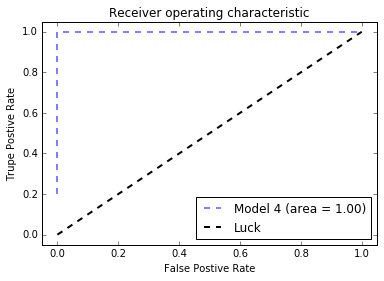

In [27]:
colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange']
lw = 2

# Train and test Model 4
X4_train = np.squeeze(X4_pruned[df4_train_idx,:])
y4_train = y4[df4_train_idx]
X4_test = np.squeeze(X4_pruned[df4_test_idx,:])
y4_test = y4[df4_test_idx]
y4_hat = classifier4.fit(X4_train,y4_train).predict_proba(X4_test)
fpr, tpr, thresholds = roc_curve(y4_test,y4_hat[:,1])
roc_auc = auc(fpr, tpr)
i = 4
plt.plot(fpr, tpr, lw=lw, color=colors[i], linestyle='--', label = 'Model %d (area = %0.2f)'%(i,roc_auc), alpha=0.5)
# Save Model 4 for model persistence
# joblib.dump(classifier4, 'classifier4.pkl')

# Plot the ROC curve for luck along with area
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Receiver operating characteristic')
plt.xlabel('False Postive Rate')
plt.ylabel('Trupe Postive Rate')
plt.legend(loc="lower right")
plt.show()



In [28]:
train_idx, test_idx, df4['Unnamed: 0'].iloc[df4_test_idx], y4_hat, y4_test

(0     Study022
 1     Study020
 4       HUP078
 6       HUP075
 7       HUP073
 8       HUP070
 9       CHOP46
 11      CHOP08
 13      CHOP20
 15    Study012
 17      CHOP45
 18    Study016
 19    Study017
 23      HUP083
 26      HUP087
 27      HUP068
 28      HUP065
 29      HUP064
 30      HUP088
 Name: Unnamed: 0, dtype: object, 2     Study029
 3     Study028
 5       HUP074
 10      CHOP47
 12      CHOP27
 14    Study019
 22      HUP086
 24      HUP082
 25      HUP080
 Name: Unnamed: 0, dtype: object, 2     Study029
 3     Study028
 5       HUP074
 10      CHOP47
 12      CHOP27
 14    Study019
 22      HUP086
 24      HUP082
 25      HUP080
 Name: Unnamed: 0, dtype: object, array([[ 0.411,  0.589],
        [ 0.574,  0.426],
        [ 0.813,  0.187],
        [ 0.713,  0.287],
        [ 0.685,  0.315],
        [ 0.594,  0.406],
        [ 0.316,  0.684],
        [ 0.676,  0.324],
        [ 0.407,  0.593]]), array([ 1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.]))

In [33]:
X4_labels

Index([u'cres_t_101_broadband_CC', u'cres_t_175_highgamma',
       u'cres_t_237_highgamma', u'cres_t_338_highgamma',
       u'cres_t_635_highgamma_zscore', u'cres_t_63_broadband_CC',
       u'cres_t_74_broadband_CC', u'cres_t_772_highgamma',
       u'cres_t_7_highgamma', u'cres_t_99_broadband_CC'],
      dtype='object')

In [29]:
X4_labels

Index([u'cres_t_131_beta_zscore', u'cres_t_153_alphatheta_zscore',
       u'cres_t_162_beta', u'cres_t_24_alphatheta_zscore',
       u'cres_t_258_lowgamma_zscore', u'cres_t_284_lowgamma_zscore',
       u'cres_t_355_alphatheta', u'cres_t_387_highgamma',
       u'cres_t_398_highgamma_zscore', u'cres_t_404_alphatheta',
       u'cres_t_415_broadband_CC_zscore', u'cres_t_427_lowgamma_zscore',
       u'cres_t_445_highgamma', u'cres_t_445_lowgamma', u'cres_t_535_beta',
       u'cres_t_575_lowgamma_zscore', u'cres_t_606_beta_zscore',
       u'cres_t_62_lowgamma_zscore', u'cres_t_655_highgamma_zscore',
       u'cres_t_719_alphatheta_zscore', u'cres_t_725_lowgamma_zscore',
       u'cres_t_746_lowgamma_zscore', u'cres_t_748_alphatheta_zscore',
       u'cres_t_762_alphatheta_zscore', u'cres_t_76_lowgamma_zscore',
       u'cres_t_790_lowgamma_zscore', u'cres_t_847_broadband_CC_zscore',
       u'cres_t_859_broadband_CC_zscore', u'cres_t_97_broadband_CC_zscore',
       u'cres_t_99_alphatheta_zscore']

In [31]:
clf = classifier4
# Generate PDF
os.system('rm *.dot')
for i_tree, tree_in_forest in enumerate(clf.estimators_):
    with open('tree_' + str(i_tree) + '.dot','w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file, feature_names=X4_labels)
os.system('dot -Tps *.dot -o all_decision_graphs.ps')
# os.system('rm *.dot')
pass

In [22]:
test_idx.shape

(9,)

In [23]:
K = k1
# Sort feature importances
importances = classifier4.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append(fname)
    print f, fname, importances[indices[f]]

    
'''
This function plots a horizontal bar plot of features sorted by importance.
'''
# Plot the feature importances of the forest
plt.figure(figsize=(12,10))
plt.title("Top %i Feature importances for VR Model"%(len(fnames)))
# Plot the feature importances of the forest
pos = range(K)
val = importances[indices[:][::-1]]

plt.barh(pos, val,
       color="r", align="center")
plt.yticks(range(K), fnames[::-1])
plt.ylim([-1, 10])
plt.savefig(os.path.expanduser('~/gdrive/aim3/fig/VR_RF_features.png'),bbox_inches='tight')

0 cres_t_74_broadband_CC 0.133701644256
1 cres_t_63_broadband_CC 0.131674049866
2 cres_t_817_broadband_CC 0.120041045034
3 cres_t_7_highgamma 0.105736938815
4 cres_t_772_highgamma 0.10504868546
5 cres_t_87_broadband_CC 0.0901155785712
6 cres_t_99_broadband_CC 0.0893979068049
7 cres_t_237_highgamma 0.0849743950188
8 cres_t_635_highgamma_zscore 0.0730840150882
9 cres_t_338_highgamma 0.0642257410867


<h1> Feature Learning </h1>

In [59]:
# Compute feature importances
clf4 = classifier4

def _helper(job):
    '''
    This helper function runs one instance of model fitting and returns the top feature importances and their name.
    '''    
    classifier,X_labels,all_labels,importances,K = job
    print K
    # Sort feature importances
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print all feature importances
    fnames = []
    for f in range(K):
        fname = X4_labels[indices[f]]
        fnames.append((fname,importances[indices[f]]))
        return fnames

    
# Parallel version
n_iter = 100
K = k1
    
def run_jobs(clf, X_train, y_train, X_labels, all_labels, K):
    '''
    This function runs n_iter instances of model fitting and keeps track of the top $K$ features. 
    This function uses multiple cores to speed up computation.
    '''
    jobs = []
    
    for n in range(n_iter):
        print n
        clf.fit(X_train, y_train)
        importances = clf.feature_importances_
        classifier = clf    
        jobs.append((classifier,X_labels,all_labels,importances,K))
    return jobs
    return_list = []
    n_proc = 40
    pool = Pool(n_proc)
    return_list = map(_helper, jobs)
    pool.close()
    return return_list

clf = clf4
X_train = X4_train
y_train = y4_train
X_labels = X4_labels
all_labels = df4.columns.difference(['Unnamed: 0','id','outcome_binary'])
return_list4 = run_jobs(clf, X_train, y_train, X_labels, all_labels, K)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [64]:
jobs = return_list4
all_importances = []
for job in jobs:
    all_importances.append(job[3])
all_importances = np.array(all_importances)
print all_importances.shape
importances = np.mean(all_importances,axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append((fname,importances[indices[f]]))
for fname, val in fnames:
    print fname,val

(100, 30)
cres_t_131_beta_zscore 0.156911741668
cres_t_748_alphatheta_zscore 0.0815748240962
cres_t_859_broadband_CC_zscore 0.0522944889336
cres_t_445_lowgamma 0.045483648891
cres_t_790_lowgamma_zscore 0.0434628878368
cres_t_153_alphatheta_zscore 0.0389302114922
cres_t_427_lowgamma_zscore 0.0362760288975
cres_t_725_lowgamma_zscore 0.030344325195
cres_t_398_highgamma_zscore 0.0302703687292
cres_t_284_lowgamma_zscore 0.0293056114174
cres_t_535_beta 0.0290317761223
cres_t_24_alphatheta_zscore 0.0283387630335
cres_t_847_broadband_CC_zscore 0.0279896906936
cres_t_575_lowgamma_zscore 0.026942422172
cres_t_355_alphatheta 0.0264095835383
cres_t_746_lowgamma_zscore 0.0250741297885
cres_t_76_lowgamma_zscore 0.0245917926389
cres_t_97_broadband_CC_zscore 0.0239663838363
cres_t_415_broadband_CC_zscore 0.0237867464279
cres_t_719_alphatheta_zscore 0.0236030888334
cres_t_387_highgamma 0.0230072787551
cres_t_606_beta_zscore 0.0225331707879
cres_t_162_beta 0.020567744159
cres_t_445_highgamma 0.020050537

broadband_CC broadband 859 0.0522944889336
broadband_CC broadband 847 0.0279896906936
broadband_CC broadband 97 0.0239663838363
broadband_CC broadband 415 0.0237867464279
alphatheta alphatheta 748 0.0815748240962
alphatheta alphatheta 153 0.0389302114922
alphatheta alphatheta 24 0.0283387630335
alphatheta alphatheta 355 0.0264095835383
alphatheta alphatheta 719 0.0236030888334
alphatheta alphatheta 762 0.0185328245698
alphatheta alphatheta 404 0.0184357950306
alphatheta alphatheta 99 0.0172153542718
beta beta 131 0.156911741668
beta beta 535 0.0290317761223
beta beta 606 0.0225331707879
beta beta 162 0.020567744159
lowgamma lowgamma 445 0.045483648891
lowgamma lowgamma 790 0.0434628878368
lowgamma lowgamma 427 0.0362760288975
lowgamma lowgamma 725 0.030344325195
lowgamma lowgamma 284 0.0293056114174
lowgamma lowgamma 575 0.026942422172
lowgamma lowgamma 746 0.0250741297885
lowgamma lowgamma 76 0.0245917926389
lowgamma lowgamma 62 0.0195510531296
lowgamma lowgamma 258 0.0193364138023
hi

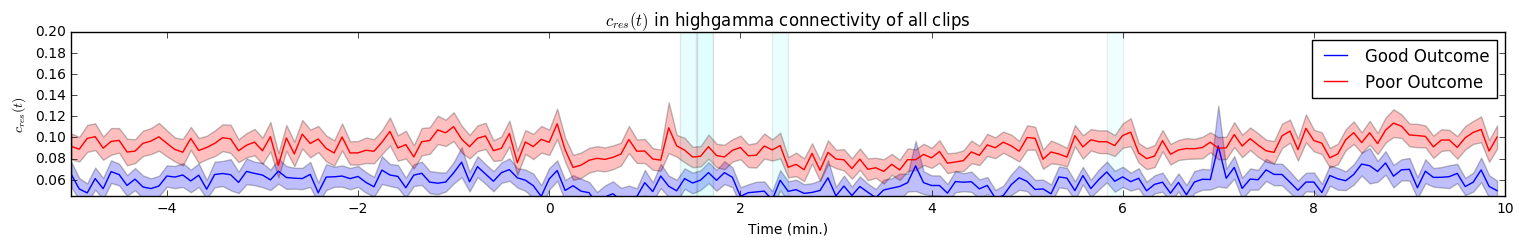

In [130]:
import sys
import glob
import json
import time

for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma','veryhigh']:
    window = 5
    dilate_radius = 0
    zscore = False
    skip_chop = False
    skip_mayo = False
    skip_hup = False
    feature = 'cres'

    all_good = []
    all_poor = []

    # All cres
    all_cres = gather_results(dilate_radius, fconn)
    
    all_good_data = np.array(())
    all_poor_data = np.array(())
    for patient_id,clips in sorted(all_cres.items(), key=lambda x:x[0]):
        if(skip_chop and 'CHOP' in patient_id):
            continue
        if(skip_mayo and 'Study' in patient_id):
            continue
        if(skip_hup and 'HUP' in patient_id):
            continue
        outcome = data['PATIENTS'][patient_id]['Outcome']
        if(get_outcome(outcome) == 'Good'):
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):                
                # if(np.isnan(clip_data).any()):
                #     continue
                if(clip_data.shape[0] == 901):
                    clip_data = clip_data[:900]
                try:
                    all_good_data = np.hstack((all_good_data,np.reshape(clip_data,(900,1))))
                except:
                    all_good_data = np.reshape(clip_data,(900,1))
        if(get_outcome(outcome) == 'Poor'):
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                # if(np.isnan(clip_data).any()):
                #     continue
                if(clip_data.shape[0] == 901):
                    clip_data = clip_data[:900]
                try:
                    all_poor_data = np.hstack((all_poor_data,np.reshape(clip_data,(900,1))))
                except:
                    all_poor_data = np.reshape(clip_data,(900,1))

    # Apply z score normalization
    if(zscore):
        for k in range(all_good_data.shape[1]):
            tmp = all_good_data[:,k].squeeze()
            all_good_data[~np.isnan(tmp),k] = scipy.stats.zscore(tmp[~np.isnan(tmp)])
        for k in range(all_poor_data.shape[1]):
            tmp = all_poor_data[:,k].squeeze()
            all_poor_data[~np.isnan(tmp),k] = scipy.stats.zscore(tmp[~np.isnan(tmp)])


    if(feature == 'abs_cres'):
        good = []
        poor = []
        for w in np.arange(0,good_cres.shape[1]+1,window):
            good.append(np.nanmean(np.abs(all_good_data[w:w+window,:]),axis=0))
            poor.append(np.nanmean(np.abs(all_poor_data[w:w+window,:]),axis=0))
        good = np.array(good)
        poor = np.array(poor)
    elif(feature == 'cres'):
        good = []
        poor = []
        for w in np.arange(0,good_cres.shape[1]+1,window):
            good.append(np.nanmean(all_good_data[w:w+window,:],axis=0))
            poor.append(np.nanmean(all_poor_data[w:w+window,:],axis=0))
        good = np.array(good)
        poor = np.array(poor)
    else:
        raise

    times = np.arange(-300.0,600,window)*1.0/60

    cres = []
    for k in good:
        cres.append(np.nanmean(k[~np.isnan(k)]))
    cres = cres[:-1]
    
    error = scipy.stats.sem(good.T,nan_policy='omit')
    error = error[:-1]
    plt.plot(times,cres,'b-')
    plt.fill_between(times,cres-error,cres+error,facecolor='blue',alpha=0.25)
    plt.hold(True)

    cres = []
    for k in poor:
        cres.append(np.nanmean(k[~np.isnan(k)]))
    cres = cres[:-1]
    error = scipy.stats.sem(poor.T,nan_policy='omit')
    error = error[:-1]
    plt.plot(times,cres,'r-')
    plt.fill_between(times,cres-error,cres+error,facecolor='red',alpha=0.25)
    
    ##### PROCESS CSV RF FEATS
    lines = open(os.path.expanduser('~/gdrive/tmp/aim3/rf_feats.csv'),'r').readlines()
    for line in lines:
        ft = line.split(',')[0]
        val = float(line.split(',')[1])
#         print ft,val
        ft_time = int(ft.split('_')[2])
        ft_fconn = ft.split('_')[3]
        if(ft_fconn == fconn or ft_fconn in fconn):
            print fconn, ft_fconn, ft_time,val
            plt.fill_between([(ft_time-5-300)/60.0, (ft_time+5-300)/60.0], np.min(cres-error)-np.abs(np.min(cres-error))*0.2, np.max(cres+error)+np.abs(np.max(cres+error))*0.5, facecolor=(val,1-val,1-val),alpha=val*4)
            pass
        

    # plt.xticks(map(lambda x: x+1, range(times.shape[0]))[::2],times[::2])
    # plt.yticks([])
    plt.xlabel('Time (min.)')
    plt.ylabel('$c_{res}(t)$')
    plt.xlim([-5.0,10.0])
    plt.ylim([np.min(cres-error)-np.abs(np.min(cres-error))*0.2, np.max(cres+error)+np.abs(np.max(cres+error))*0.5])
    plt.title('$c_{res}(t)$ in %s connectivity of all clips'%(fconn))
    plt.legend(['Good Outcome','Poor Outcome'])
#     plt.show()
    fig = plt.gcf()
    fig.set_size_inches(18.5,2.11)
    fig.savefig(os.path.expanduser('~/gdrive/aim3/fig/ROZ_delta_clip_%s_with_fts.png'%(fconn)),dpi=100,bbox_inches='tight')
    plt.hold(False)

In [ ]:
from operator import itemgetter

return_list = return_list4
final_feature_dict = {}
for res in return_list:
    for fn,imp in res:
        if(fn not in final_feature_dict.keys()):
            final_feature_dict[fn] = [imp]
        else:
            final_feature_dict[fn].append(imp)
results = sorted(final_feature_dict.items(), key=itemgetter(1), reverse=True)

# Plot the feature importances of the forest
plt.figure(figsize=(12,10))
plt.title("Top %i Feature counts for Model %i"%(K, model_number))
# Plot the feature importances of the forest
pos = range(K)
val = map(lambda x: x[1], results)
val = np.array(val)/(1.0*max(val))
fnames = map(lambda x: x[0], results)
val = val[:K][::-1]
fnames = fnames[:K][::-1]
plt.barh(pos, val,
       color="r", align="center")
plt.yticks(range(K), fnames)
plt.ylim([-1, K])
plt.show()

In [ ]:
K = 10
# Sort feature importances
importances = classifier4.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append(fname)
    print f, fname, importances[indices[f]]

    
'''
This function plots a horizontal bar plot of features sorted by importance.
'''
# Plot the feature importances of the forest
plt.figure(figsize=(12,10))
plt.title("Top %i Feature importances for VR Model"%(len(fnames)))
# Plot the feature importances of the forest
pos = range(K)
val = importances[indices[:][::-1]]

plt.barh(pos, val,
       color="r", align="center")
plt.yticks(range(K), fnames[::-1])
plt.ylim([-1, 10])
plt.savefig(os.path.expanduser('~/gdrive/aim3/fig/VR_RF_top_robust_features.png'),bbox_inches='tight')